In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Requirements

This notebook ran on Kaggle with a GPU.  
The ECG data set has to be included first

# Transfer learning 

fine tune the last layer of a 2D image classification model
* EfficientNetB0
* resnet50

for both the input size is (3,224,224)

## Methodology

* build a balanced dataset with signal modification in order to get a 10 000-signals-per-class dataset
* transform 1D signal with a continous wavelet transforms
* data augmentation on the fly within the batch. this includes only time shift and gaussian filtering


the wavelets used are :
* cgaus
* mexh
* cmor

Normalization factor is computed from the train dataset

### loading functions to get a balanced dataset

In [1]:
import pandas as pd
import numpy as np

import os 
from scipy import signal, interpolate
from sklearn.utils import shuffle

import matplotlib.cm as cm

import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import os 
from scipy import signal, interpolate
from sklearn.utils import shuffle


# a recoder: serait plus pratique avec une classe
# charge les données brute
def load(file='../data/raw/mitbih_train.csv'):
    if not os.path.isfile(file):
        raise ValueError('file not found')
    df = pd.read_csv(file,header=None)
    target = df.pop(df.columns[-1])
    X = np.array(df)
    y = np.array(target)

    return X,y

# charge les données et sort un dataset equilibré
def load_balanced_data(file='../data/raw/mitbih_train.csv', 
                       method='under',
                       n_normal=6500,
                       smote_perturb_smote_ratio=0.5,
                       plow=0.85,phigh=1.15,slopelow=-0.1,slopehigh=0.1,strechlow=-5,strechhigh=5):
    if method not in ['under','smote','perturb','smote-perturb']:
        raise ValueError('mode must be "under","smote","perturb" or "smote-perturb"')
                         
    X,y = load(file)

    X_rs,y_rs = sampling_strategy(X,y,method=method,n_normal=n_normal,smote_perturb_smote_ratio=smote_perturb_smote_ratio,
                                 plow=plow,phigh=phigh,slopelow=slopelow,slopehigh=slopehigh,strechlow=strechlow,strechhigh=strechhigh)
    return X_rs,y_rs 
    
    
# radom selection of N classe 0 signals 
def random_subsample_classe(y,n_normal,classe=0):
    """
    # inputs
    ------------
    y = a 1D array defining classification
    # outputs
    ------------
    selected_indices : indices within y of size n_normal:  n_normal random indices of y = classe
    # example
    ------------
    I want 10 signals randomly selected within classe 4, this will give the 10 indices to apply to y
    random_subsample_classe(y,10,classe=4)
    """
    bool_0 = y == classe
    ii_0 = [k for k,x in enumerate(bool_0) if x]
    ii_0 = shuffle(ii_0,random_state=123)
    selected_indices = ii_0[0:n_normal]
    return selected_indices

def sampling_strategy(X,y,method='under',n_normal=6500,smote_perturb_smote_ratio=0.5,
                     plow=0.85,phigh=1.15,slopelow=-0.1,slopehigh=0.1,strechlow=-5,strechhigh=5):
    
    """
    Balance the dataset
    # inputs
    ------------
    X, y : data and target
    method :
        - under : apply undersampling: the number of samples per class is the number of the minority class
        - smote : apply oversamplng : the number of samples per class is n_normal
        - perturb : apply low perturbation on the signals so that all the number of samples per class is n_normal. append the classes that have less than  n_normal sample, if the class has more than n_normal samples, then random undersample
        - smote-perturb : combine smote and perturb with smote_perturb_smote_ratio using smote and 1-smote_perturb_smote_ratio using perturb
    # outputs
    ------------
    """
    
    if method not in ['under','smote','perturb','smote-perturb']:
        raise ValueError('mode must be "under","smote","perturb" or "smote-perturb"')
    if method == 'under':
        ru = RandomUnderSampler(random_state=123)
        X_rs, y_rs = ru.fit_resample(X,y)
    elif method == 'smote':
        ii_0 = random_subsample_classe(y,n_normal,classe=0)
        X1 = np.concatenate((X[ii_0,:],X[y != 0,:]), axis=0)
        y1 = np.concatenate((y[ii_0],y[y != 0]))
    
        sm = SMOTE(random_state=123,sampling_strategy='not majority') 
        X_rs, y_rs = sm.fit_resample(X1 ,y1)
    elif method == 'perturb':
        ii_0 = random_subsample_classe(y,n_normal,classe=0)
        X1 = np.concatenate((X[ii_0,:],X[y != 0,:]), axis=0)
        y1 = np.concatenate((y[ii_0],y[y != 0]))
    
        X_rs, y_rs = augmentbase_shape(X1,y1,n_normal)
    elif method == 'smote-perturb':
        nsmote = int(n_normal*smote_perturb_smote_ratio)
        npeturb = n_normal - nsmote
        
        c = pd.Series(y).value_counts()
        too_many = c.index[c>nsmote]
        too_many_bool = np.zeros(X.shape[0], dtype=bool)
        selected_indices_smote = []
        selected_indices_perturb = []
        for cl in too_many:
            ii_0 = random_subsample_classe(y,n_normal,classe=cl)
            print('nsmote: ',nsmote,' , nperturb: ',npeturb)
            selected_indices_smote += ii_0[0:nsmote]
            selected_indices_perturb += ii_0[nsmote:n_normal]
            too_many_bool = np.logical_or(too_many_bool,y == cl)
            
        
        other_classes = np.logical_not(too_many_bool)
        X1 = np.concatenate((X[selected_indices_smote,:],X[other_classes,:]), axis=0)
        y1 = np.concatenate((y[selected_indices_smote],y[other_classes]))

        X2 = np.concatenate((X[selected_indices_perturb,:],X[other_classes,:]), axis=0)
        y2 = np.concatenate((y[selected_indices_perturb],y[other_classes]))
        
        X_sm, y_sm = sampling_strategy(X1,y1,'smote',nsmote)
        print('after smote')
        print(pd.Series(y_sm).value_counts())
        X_pe, y_pe = sampling_strategy(X2,y2,'perturb',npeturb)

        X_rs = np.concatenate((X_sm,X_pe), axis=0)
        y_rs = np.concatenate((y_sm,y_pe))
        
    return X_rs, y_rs
    
def signal_temporal_trend(x,pente,no_change_index):
    """
    # inputs
    -------------
        - x : signal np.array(npts)
        - pente : float : slope to apply to the data
        - no_change_index : int, value at index no_change_index is not modified :  x_out[no_change_index] = x[no_change_index]
    """
    # applique une trend lineaire au signal . au point no_change_index, le coef vaut 1 
    # la pente de la trend est m
    coef = pente/no_change_index*np.arange(x.shape[0])+1+pente
    return coef*x


def augment(x,plow=0.85,phigh=1.15,slopelow=-0.1,slopehigh=0.1,strechlow=-5,strechhigh=5):
    """
    # inputs
    -------------
        - x : signal np.array(npts)
        - plow,phigh  : float :min and max power to apply (signal_temporal_trend)
        - slopelow,slopehigh  : float :min and max slope to apply (signal_temporal_trend)
    apply a perturbation including randomly between the bounds:
        - streching
        - add linear slope
        - signal to the power 
         """
    np.random.seed(123)
    # p : mise a la puissance p
    p = np.random.uniform(low=plow, high=phigh)
    # c : application d'une trend lineaire, au point c, la trend vaut 1
    # c = int(np.random.uniform(low=20,high=160))
    # je crois que c ne sert à rien ca apres les data sont renormalisée, donc je le met au milieu
    c= x.shape[0] //2 
    # pente de la trend
    m = np.random.uniform(low=slopelow,high=slopehigh)
    # applique une puissance au signal
    a = signal_temporal_trend(x,m,c)**p
    a = a/(max(a)-min(a))
    
    # streching
    Nadd = np.random.randint(low=strechlow,high=strechhigh)
    if Nadd !=0:
        f = interpolate.interp1d(np.arange(0, x.shape[0]), a)
        a = f(np.linspace(0.0, x.shape[0]-1, x.shape[0]+Nadd))
    if Nadd<0:
        b = np.zeros(shape=(x.shape[0], ))
        b[0:x.shape[0]+Nadd] = a
        a = b
    else:        
        a = a[0:x.shape[0]]
    return a


def augmentbase_shape(X_data,y_data,n_per_class,plow=0.85,phigh=1.15,slopelow=-0.1,slopehigh=0.1,strechlow=-5,strechhigh=5):
    X2 = None
    y2 = None
    npts = X_data.shape[1]
    print(np.unique(y_data))
    np.random.seed(123)
    for classe in np.unique(y_data):
        # indices des signaux de classe "classe"
        index_of_class = [k for k,x in enumerate(y_data) if x==classe]
        if len(index_of_class) > n_per_class:
            print('class ',classe,' undersampling')
            index_of_class = shuffle(index_of_class,random_state=123)
            DataAdd = X_data[index_of_class[0:n_per_class],:]
            Yadd = y_data[index_of_class[0:n_per_class]]       
        else:
            Nmissing = n_per_class-len(index_of_class)
            print('class ',classe,' oversampling, missing ',Nmissing)
            ii = np.random.choice(index_of_class,Nmissing)
            data_temp = np.zeros((Nmissing,npts))
            for kk,jj in enumerate(ii):
                data_temp[kk,:] = augment(X_data[jj,:],plow=plow,phigh=phigh,slopelow=slopelow,slopehigh=slopehigh,strechlow=strechlow,strechhigh=strechhigh)
                
            DataAdd = np.concatenate((X_data[index_of_class,:],data_temp),axis=0)
            Yadd =  np.ones(DataAdd.shape[0])*classe
            #print('class ',classe,' add ', data_temp.shape[0],'new shape',DataAdd.shape[0],',',Yadd.shape[0])
       
        if X2 is None:
            X2 = DataAdd
            y2 = Yadd
        else:
            X2 = np.concatenate((X2,DataAdd),axis=0)
            y2 =np.concatenate((y2,Yadd))
    return X2,y2



In [2]:
import os
import sys
import time
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d
import joblib
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import optim

from scipy.signal import cwt,ricker,morlet2
import pywt
from scipy import ndimage


## Load Dataset

In [ ]:
X_train, y_train = load_balanced_data('/kaggle/input/heartbeat/mitbih_train.csv', method='perturb',n_normal=10000,strechlow=-10,strechhigh=15)
#X_train, y_train = load_balanced_data('../data/raw/mitbih_train.csv', method='perturb',n_normal=10000,strechlow=-10,strechhigh=15)



Check the dataset is balanced

<Axes: xlabel='None', ylabel='count'>

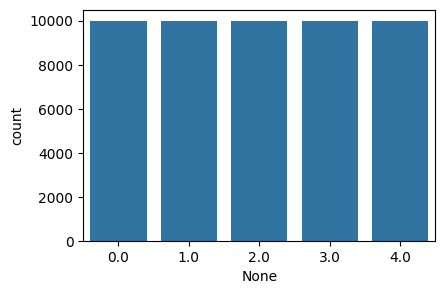

In [9]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
sns.countplot(x=pd.Series(y_train),ax=ax)

#### split the dataset as test and train

In [11]:
X_train,X_cross, y_train, y_cross = train_test_split(X_train,y_train,test_size=0.15,random_state=12)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

cross_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))
cross_loader = DataLoader(cross_set, batch_size=32, shuffle=True)


Text(0.5, 1.0, 'Cross-val')

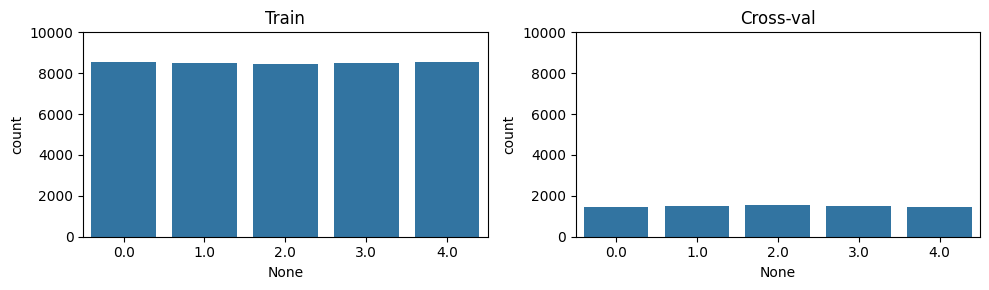

In [7]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
sns.countplot(x=pd.Series(y_train),ax=ax)
ax.set_ylim([0,10000])
ax.set_title('Train')
ax = fig.add_subplot(122)
sns.countplot(x=pd.Series(y_cross),ax=ax)
ax.set_ylim([0,10000])
fig.tight_layout()
ax.set_title('Cross-val')

In [ ]:
np.savez('/kaggle/working/cross.npz', X_cross=X_cross,y_cross=y_cross)

## Continuous Wavelet transform

this function applies the wavelet transfrom to a set of signals as a Tensor (Nsignals x Nsamples)  
it requires the normalization factor to get 2D images within the interval [0-1]

In [19]:
def pywtsig2cwtimage_tensornoloop(X,wavelet='cgau1',cwtNorm=1,widths=None):
   
    if widths is None:
        freq = np.linspace(1, 125/2, 224)
        widths = 5*125 / (2*freq*np.pi)
    
   
    coef, freqs=pywt.cwt(X.detach().numpy(),widths,wavelet, sampling_period=1/125)
    Y = np.sqrt(abs(coef)/cwtNorm).swapaxes(0, 1)
    pad = np.zeros((Y.shape[0],Y.shape[1],37))
    return torch.from_numpy(np.concatenate((Y,pad),axis=-1))
   # return torch.from_numpy(Y)

this function compute the max of the wavelet transform and is used to estimate the normalization factor to apply to the wavelet transform

In [20]:
def checknormcoeff(X,widths,wavelet='cgau1'):
    # X tensor : Nsignals x N samples
    # widths = scales of the wavelets
    # retrun the max all transforms
   
    coef, freqs=pywt.cwt(X.detach().numpy(),widths,wavelet, sampling_period=1/125)
    Z = abs(coef)
   
    c = Z.max()
    return c 

## wavelet transform

we need to define the wavelet and the scale factors to use. the number of scale factors gives one dimension of the image. the second dimension is the number of samples of the signals. 

##### widths

scales factors for each wavelets. they are taken such as the scale2frequency(withs) fonction retruns about the same frequencies for each wavelet

224 samples are used in the widths vector because we are going to apply an image classification model with input size =  224,224

In [16]:
widths = {'cgau1': np.geomspace(0.6, 75, num=224),
          'mexh':  np.geomspace(0.5, 62.5, num=224),
          'cmor2.5-0.5': np.geomspace(1, 125, num=224)}

##### normalization coefficient

set this next markdown as code to recompute the normalization coefficients 

Cnorm = {}
for wavelet  in ['cmor2.5-0.5','cgau1','mexh']:
    m=0

    progress_bar = tqdm(
                train_loader, desc="train", leave=True, disable=False
            )
    for X_batch,_ in progress_bar:
        mnew =  checknormcoeff(X_batch,widths[wavelet],wavelet=wavelet)
        if mnew>m:
            print(mnew)
            m = mnew
    Cnorm[wavelet] = m
    

Cnorm = {'cgau1':2.289909 ,
        'mexh': 2.786098,
        'cmor2.5-0.5':1.5264213}

 to save time, the coefficient were already computed

In [15]:
Cnorm = {'cgau1':4.9093666 ,
        'mexh': 7.26381,
        'cmor2.5-0.5':2.1747324}

Examples of wavelet transforms

0.6348610520362854
0.5839775800704956
0.46278879046440125
0.4009946286678314
0.8032863140106201
0.6601453423500061
0.5881478786468506
0.46307021379470825
0.38805511593818665
0.7978134155273438
0.43591955304145813
0.5290595293045044
0.4026983678340912
0.3854023218154907
0.7560083270072937


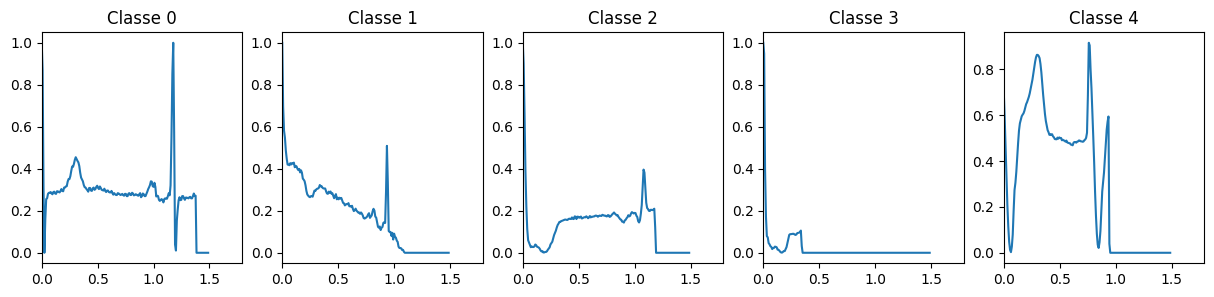

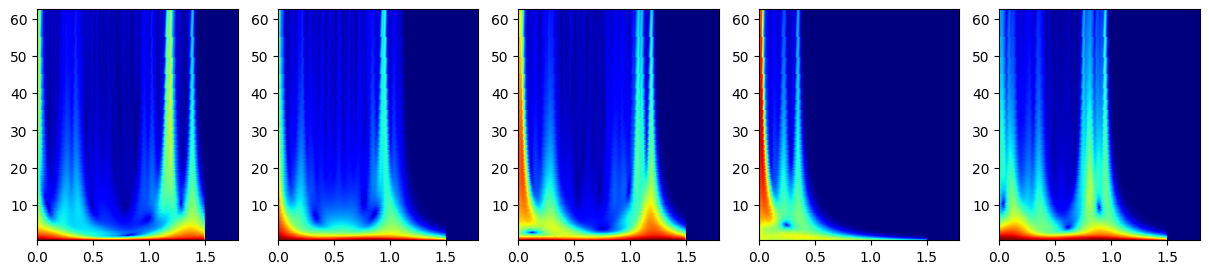

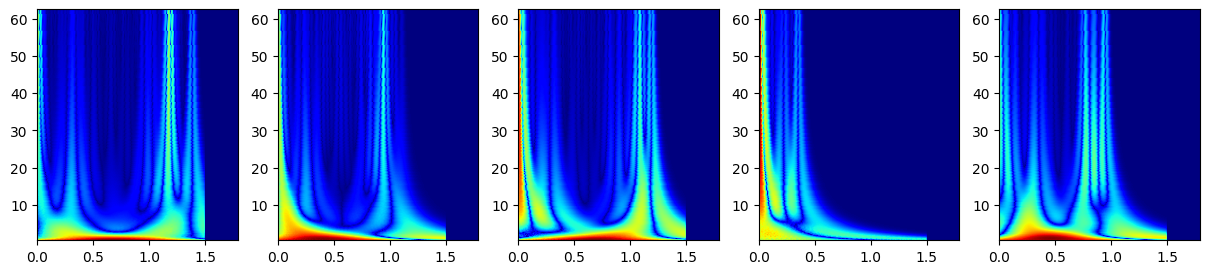

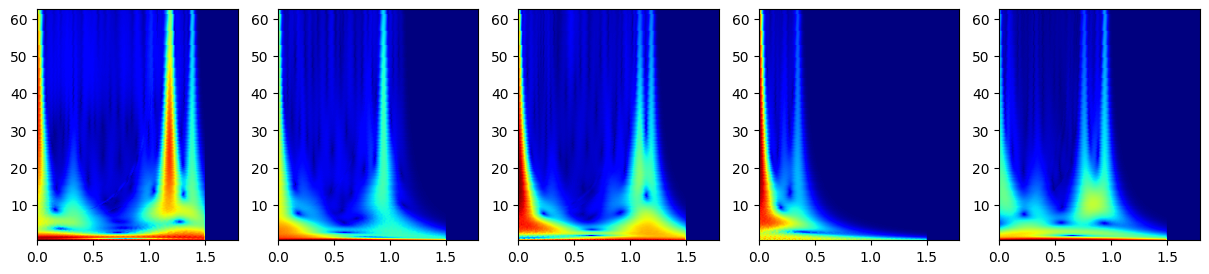

In [22]:
examples = [np.argmax(y_train==0),np.argmax(y_train==1),np.argmax(y_train==2),np.argmax(y_train==3),np.argmax(y_train==4)]

fig, axs = plt.subplots(figsize=(15,3),nrows=1,ncols=5)
for ii in range(5):
    axs[ii].plot(np.arange(187)/125,X_train[examples[ii],:])
    axs[ii].set_title('Classe %d' %ii)
    axs[ii].set_xlim([0,224/125])

for wavelet in ['cgau1','mexh',"cmor2.5-0.5"]:
    
    fig, axs = plt.subplots(figsize=(15,3),nrows=1,ncols=5)
    w = widths[wavelet]
    freqs=pywt.scale2frequency(wavelet, w)*125
    # show one example for each class (the first one)
    for ii in range(5):
        
        
        Z = pywtsig2cwtimage_tensornoloop( torch.Tensor(np.expand_dims(X_train[examples[ii],:],axis=0)),
                                          wavelet=wavelet,cwtNorm =Cnorm[wavelet])
       
        axs[ii].imshow(Z[0],aspect='auto',cmap='jet',extent=[0,224/125,freqs[0],freqs[-1]])
        axs[ii].set_ylim([freqs[-1],freqs[0]])
        axs[ii].set_xlim([0,Z.shape[-1]/125])
        print(Z.max().item())

## Data augmentation on the fly 

Gaussian filter using neural network module

In [27]:
Gau = []
with torch.no_grad():
    for sigma in [0.5,0.7]:
        weights = ndimage._filters._gaussian_kernel1d(sigma, 0, int(4 * sigma + 0.5))[::-1]
        conv = nn.Conv1d(1, 1, weights.shape[0], stride=1, padding='same',bias=False)
        for k in range(conv.weight.shape[2]):
            conv.weight[0,0,k]= torch.tensor(weights[k])
        Gau.append(conv)

signal modification functions:
* linear amplification : (a*t+b)*f(t)
* power : f(t)**p
* time shift f(t-a)
* signal streching

In [29]:
 
def random_signal_temporal_trend_tensor(X_batch,no_change_index=93,slopelow=-0.1,slopehigh=0.1):
    """
    # inputs
    -------------
        - x : signal np.array(npts)
        - pente : float : slope to apply to the data
        - no_change_index : int, value at index no_change_index is not modified :  x_out[no_change_index] = x[no_change_index]
    """
    # applique une trend lineaire au signal . au point no_change_index, le coef vaut 1 
    # la pente de la trend est m
    pente = (slopehigh-slopelow)*torch.rand(size=(X_batch.shape[0],1),dtype=torch.float32)+slopelow
    coef=(torch.arange(X_batch.shape[1],dtype=torch.float32) - (X_batch.shape[1]//2))*(pente)/X_batch.shape[1]+1
    jj = np.unique(np.random.randint(X_batch.shape[0],size=(X_batch.shape[0]//2)))
    X_batch[jj,:] = coef[jj,:]*X_batch[jj,:]
    return X_batch

def random_power_tensor(X_batch,plow=0.85,phigh=1.15,slopelow=-0.1,slopehigh=0.1,strechlow=-5,strechhigh=5):

    jj = np.unique(np.random.randint(X_batch.shape[0],size=(X_batch.shape[0]//2)))
    power= (phigh-plow)*torch.rand(size=(X_batch.shape[0],1),dtype=torch.float32)+plow
    X_batch[jj,:] = X_batch[jj,:].pow(power[jj])
    
    return X_batch
    
def stretch_signal(x,n_samples=187,strechlow=-5,strechhigh=5):
    Nadd = np.random.randint(low=strechlow,high=strechhigh)
    if Nadd !=0:
        f = interpolate.interp1d(np.arange(0, n_samples),x)
        x = torch.Tensor(f(np.linspace(0.0, n_samples-1, n_samples+Nadd)))
    if Nadd<0:
        b = torch.Tensor(np.zeros(shape=(n_samples, )))
        b[0:n_samples+Nadd] = x
        x = b
    else:        
        x = x[0:n_samples]
    return x

def random_gaussian(X_batch,Gau):
    with torch.no_grad():
        n_filter_gauss = len(Gau)
        jj = np.unique(np.random.randint(X_batch.shape[0],size=(X_batch.shape[0]//2)))
        gn = int(len(jj)/n_filter_gauss)
        firstsamples = X_batch[:,0:3].clone()
        for kg in range( n_filter_gauss):
            ii_gauss = jj[kg*gn:(kg+1)*gn]     
            X_batch[ii_gauss,:] =  (Gau[kg](X_batch[ii_gauss,:].unsqueeze(1)))[:,0,:]
        X_batch[:,0:3] = firstsamples
    return X_batch
        
def random_time_shift(X_batch):

    jj = np.unique(np.random.randint(X_batch.shape[0],size=(X_batch.shape[0]//2)))
    n_zeros_pad = ((X_batch.flip(dims=[1])!=0)).to(float).argmax(dim=1)
    n_zeros_pad = n_zeros_pad.detach().numpy().flatten()

    for ii in jj:
        if n_zeros_pad[ii]>0:
            X_batch[ii,:] = X_batch[ii,:].roll(np.random.randint(n_zeros_pad[ii]),dims=[0])
    return X_batch
    
def random_stretch(X_batch,strechlow=-5,strechhigh=5):

    jj = np.unique(np.random.randint(X_batch.shape[0],size=(X_batch.shape[0]//2)))
    for ii in jj:
        X_batch[ii,:] = stretch_signal(X_batch[ii,:],strechlow=-strechlow,strechhigh=strechhigh)
        
    return X_batch
    
def renormalize(X_batch):
    return (X_batch - X_batch.min(axis=1,keepdim=True)[0]) / (X_batch.max(axis=1,keepdim=True)[0] - X_batch.min(axis=1,keepdim=True)[0])



Data augmentation apply transforms. we only keep gaussina and time shift because the others were already applied by loading the balanced dataset

In [24]:
def data_augmentation(X_batch,Gau):
       
    # random amplification
     #X_batch = random_signal_temporal_trend_tensor(X_batch)
    # random power
     #X_batch = random_power_tensor(X_batch)
    # random strecth
     #X_batch = random_stretch(X_batch,strechlow=-10,strechhigh=15)
     # random gaussian
    X_batch = random_gaussian(X_batch,Gau)
    # random time shift
    X_batch = random_time_shift(X_batch)
    # normalize
    X_batch = renormalize(X_batch)
   
    return X_batch

#### data augmentation example

In [25]:
def showexample(K,X_batch,Xref,title):
    if isinstance(K,int):
        K = [K]
    N = len(K)
    cmap = cm.get_cmap('jet')
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot()
    for k in K:
        ax.plot(Xref[k,:],linestyle=':',color=cmap(k/N))
        ax.plot(X_batch[k,:],color=cmap(k/N))
    ax.set_title(title)

In [30]:
X_batch,y_batch = next(iter(train_loader))
X1 = X_batch.clone()
X_batch = data_augmentation(X_batch,Gau)

C:\Users\passage\AppData\Local\Temp\ipykernel_13184\406047243.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


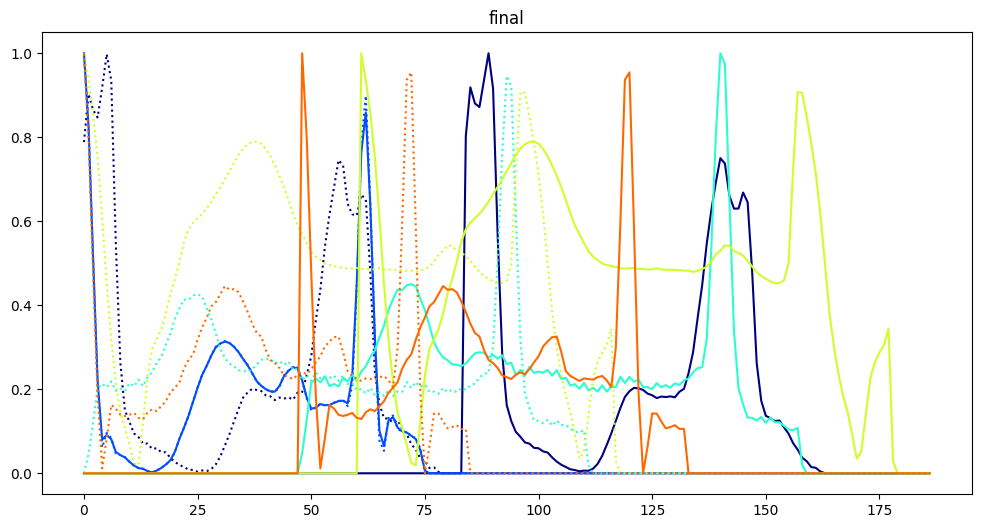

In [31]:
showexample(range(5),X_batch,X1,'final')


## MODEL

Comment or uncomment one of these 2 blocks to used EfficientNet or ResNet50

In [ ]:
mytype = '3layers'
version = '16'

### resnet/EfficientNet

In [ ]:
if mytype== '3layers':
    model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    
    num_features = model.fc.in_features
    newclassifier = nn.Sequential(nn.Dropout(),
                             nn.Linear(num_features, 128),
                             nn.Linear(128, 5))
    model.fc = newclassifier
    modelname = 'ResNet'
else:
    model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.classifier[-1].in_features
    newclassifier = nn.Sequential(nn.Dropout(),
                             nn.Linear(num_features, 128),
                             nn.Linear(128, 5))
    #print(model.classifier[-1].in_features)
    model.classifier[-1] = newclassifier
    modelname = 'EffNet'

### images channels

set mytype to '3layers' to make 3 wavelet transforms and use 1 for each image channel  
otherwise only the cgauss is used and triplicated 

## Train

1D signal to 2D image

In [ ]:
def transformXbatch(X_Tensor,mytype):
    
    X = X_Tensor.clone()
    X_batch = pywtsig2cwtimage_tensornoloop(X,wavelet='mexh',
                                    widths=widths['mexh'],
                                   cwtNorm =Cnorm['mexh'])
    X_batch = X_batch.unsqueeze(1).expand([-1,3,-1,-1])
    if mytype== '3layers':
        X_batch[:,1,:,:] = pywtsig2cwtimage_tensornoloop(X,wavelet='cgau1',
                                               widths=widths['cgau1'],
                                               cwtNorm =Cnorm['cgau1'])

        X_batch[:,2,:,:] = pywtsig2cwtimage_tensornoloop(X,wavelet='cmor2.5-0.5',
                                               widths=widths['cmor2.5-0.5'],
                                              cwtNorm =Cnorm['cmor2.5-0.5'])
    return X_batch

In [ ]:
def evaluate_model(model, test_loader, mytype, device='cpu'):
    progress_bar = tqdm(
            test_loader, desc="test full", leave=True, disable=False
        )
   
    loss_test=0
    y_pred = []
    y_true = []
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    for batch in progress_bar:
        # Batch de données
        X_val, y_val = batch


        X_val = transformXbatch(X_val,mytype)

        X_val = X_val.to(device)
        y_val = y_val.to(device)
        
        with torch.no_grad():
            pred = model(X_val.to(torch.float32))
        # compute loss for batch
        loss = criterion(pred, y_val)

        # get classification
        pred = np.argmax(pred.detach().cpu().numpy(),axis=1)
        
        # update predictions and true Y
        y_pred += list(pred)
        y_true += list(y_val.detach().cpu().numpy())
        # update total loss
        loss_test += loss.item()
      
        #print(np.array(y_true).shape,np.array(y_pred).shape)
    loss_test = loss_test/len(test_loader)
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
epochs = 100
print(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()
loss_list = []
recall_list= []
accuracy_list = []

loss_list_test = []
accuracy_list_test = []
recall_list_test = []
model = model.to(device)

best_val_loss = 10000



In [ ]:

# Définition de l'optimizer

for epoch in range(epochs):
    #"""
    progress_bar = tqdm(
            train_loader, desc="train", leave=True, disable=False
        )
    
    # Dans ce mode certaines couches du modèle agissent différemment
    model.train()
    loss_total = 0
    # Barre de progression
    predictions_train = []
    true_train = []
   
    for i, batch in enumerate(progress_bar):
        
        # Batch de données
        X_batch, y_batch = batch
        # to device
        y_batch = y_batch.to(device)
        # 1D to 2D 
        X_batch = data_augmentation(X_batch,Gau)

        X_batch = transformXbatch(X_batch,mytype)
        # to device
        X_batch = X_batch.to(device)
        # Gradient mis 0
        model.zero_grad()
        # Calcul de prédiction
        outputs = model(X_batch.to(torch.float32))
        # Calcul de la fonction de perte
        loss =  criterion(outputs, y_batch) 
        
        # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
        loss.backward()
        
        # Clipper le gradient entre 0 et 1 pour plus de stabilité
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Descente de gradient : actualisation des paramètres
        optimizer.step()
        
        predictions_train.extend(outputs.detach().cpu().numpy())
        true_train.extend(y_batch.detach().cpu().numpy())
        
    
       
        
        loss_total += loss.item()

    
    
     # classification
    y_pred_train = np.argmax(np.array(predictions_train),axis=1)

    recall_list.append(recall_score(true_train, y_pred_train,average='macro'))
    accuracy_list.append(precision_score(true_train, y_pred_train,average='macro'))
    loss_list.append(loss_total/len(train_loader))

    #"""
    # Évaluer sur l'ensemble de validation
    y_true, y_pred, accuracy_test, recall_test, val_loss = evaluate_model(model, cross_loader,mytype,device=device)
            
    if val_loss< best_val_loss:
        best_val_loss = val_loss 
        joblib.dump(model.to('cpu'),'/kaggle/working/tl_v'+version+'_'+modelname+'_%d.pkl' %epoch)
        model.to(device)
        
    loss_list_test.append(val_loss)
    accuracy_list_test.append(accuracy_test)
    recall_list_test.append(recall_test)

    pd.DataFrame({'loss_test':loss_list_test,
                  'accuracy_test':accuracy_list_test,
                  'recall_test':recall_list_test,
                 'loss':loss_list,
                  'accuracy':accuracy_list,
                  'recall':recall_list}).to_csv('/kaggle/working/history.csv')

    # Mise à jour du scheduler
    #scheduler.step(val_loss)
    # Affichage de la perte de validation à la fin de l'époque
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss_total/len(train_loader):.3f}, Validation Loss: {val_loss:.3f}")

In [ ]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
#ax.plot(loss_list,label='loss train')
ax.plot(loss_list_test,label='loss test')
ax.legend()
ax = fig.add_subplot(122)
#ax.plot(accuracy_list,label='accuracy train')
ax.plot(accuracy_list_test,label='accuracy test')

In [ ]:
X_test, y_test = load('/kaggle/input/heartbeat/mitbih_test.csv')
print(X_test.shape)

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))
test_loader = DataLoader(test_set, batch_size=32)

## Eval on test dataset

In [ ]:
model = joblib.load('/kaggle/working/tl_v13_res50_12.pkl')

In [ ]:
model.to(device)

In [ ]:
X_test, y_test = load('/kaggle/input/heartbeat/mitbih_test.csv')
print(X_test.shape)

test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.Tensor(torch.from_numpy(y_test).long()))
test_loader = DataLoader(test_set, batch_size=32)

In [ ]:
y_true, y_pred, accuracy, recall, loss_test = evaluate_model(model,test_loader,device=device)

print(classification_report(y_true, y_pred,digits=3))
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')